<a href="https://colab.research.google.com/github/jhchang/ArabicDialectDetector/blob/main/04_transformer_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Arabic Dialect Classification with Transformer Models

## 📜 Table of Contents:
- Intro
- What is a Transformer
- Preprocessing dataset
- Loading CAMeLBERT
- Fine Tuning the model
- Saving the Model
- Loading the model
- Evaluating on test set
- Analysis of results
- Conclusions

---

In this notebook, we fine-tune **state-of-the-art Arabic transformer models** for the task of **Arabic dialect identification** using the MADAR Corpus. Transformer based models are used in all the popular Large Language Models (LLMs) such as ChatGPT, Deepseek, BERT, Gemini, Grok, etc. This dataset includes short text samples labeled across **26 distinct Arabic dialects and MSA**, making it a challenging multiclass classification problem due to the high degree of lexical and syntactic similarity between dialects.

---

### 🎯 Objective

Our goal is to improve upon traditional baselines (TF-IDF, MLP, Naive Bayes, SVM, CNN, BiLSTM) by leveraging **pretrained transformer models** that have been trained on large Arabic corpora. These models provide deep contextual understanding, especially valuable in:

* ✅ Morphologically rich language like Arabic
* ✅ Dialects with overlapping vocabulary
* ✅ Short text sequences (≤16 tokens per sample)

---

### ⚙️ Why Use Transformers?

Unlike traditional deep learning models, transformer-based architectures:

* Use **multi-headed self-attention** to capture long-range and nuanced dependencies
* Do not rely on sequential memory (unlike LSTMs or RNNs) thus capturing long-range dependencies
* Offer **state-of-the-art results** on a variety of NLP tasks in Arabic, especially dialect classification
* Pays **context-aware attention** to all words in the input
* Provides **strong generalization** from limited data

We focus on fine-tuning pretrained Arabic models such as:

| Model         | Strength                                                | HF Model ID                        |
| ------------- | ------------------------------------------------------- | ---------------------------------- |
| **AraBERT**   | General-purpose Arabic (MSA + dialects) from news & web | `aubmindlab/bert-base-arabertv02`  |
| **MARBERT**   | Dialect-heavy, trained on 1B+ Arabic tweets             | `UBC-NLP/MARBERT`                  |
| **CAMeLBERT** | Focused on dialect classification and morphology        | `CAMeL-Lab/bert-base-camelbert-da` |

---

### 🧪 In This Notebook

* ✅ Load and preprocess the MADAR dataset

* ✅ Tokenize with the appropriate Hugging Face tokenizer

* ✅ Fine-tune a transformer model on the training data

* ✅ Evaluate performance using validation accuracy and confusion matrix

* ✅ Compare results with previous non-transformer models

---

## 🇸🇦 Relevance to Saudi Vision 2030

Accurate Arabic dialect classification supports several **Vision 2030** goals related to digital transformation, AI, and cultural preservation. In particular, it enables:

* ✅ **Intelligent virtual assistants** and **chatbots** that understand local dialects, improving user engagement in government and private sector services.
* ✅ **Voice recognition systems** adapted to regional Arabic varieties, essential for smart city initiatives and inclusive AI.
* ✅ **Cultural analysis and content moderation** across social media platforms to ensure alignment with Saudi norms and sentiment.
* ✅ Enhancements in **Arabic NLP infrastructure**, contributing to Saudi Arabia’s ambition to lead in Arabic AI research and development.

This project reflects the growing need for **dialect-aware AI systems** that can operate effectively across the Arab world — a priority as the Kingdom expands its digital economy and AI capabilities.

---


#What is a Transformer?

In machine learning, a **transformer** is a type of **deep learning model architecture** introduced in the paper **"Attention Is All You Need"** by Vaswani et al. in 2017. It was originally designed for **natural language processing (NLP)** tasks, such as machine translation, but has since become a foundational architecture across many domains, including vision, audio, and reinforcement learning.

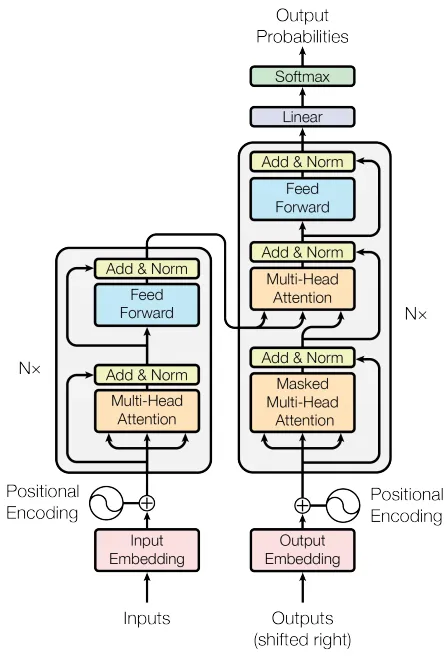

### Key Characteristics of Transformers:

1. **Self-Attention Mechanism**:

   * The core innovation of the transformer is the **self-attention** mechanism, which allows the model to weigh the importance of different words (or tokens) in a sequence relative to each other.
   * For example, in the sentence "The cat sat on the mat," the model can understand that "cat" is more relevant to "sat" than "mat" is.

2. **Parallelization**:

   * Unlike RNNs (recurrent neural networks), transformers process all tokens in a sequence **simultaneously**, not sequentially. This leads to much faster training times and better scalability.

3. **Layered Architecture**:

   * Transformers are composed of **stacked layers** that include:

     * Multi-head self-attention
     * Feed-forward neural networks
     * Layer normalization
     * Residual (skip) connections

4. **Positional Encoding**:

   * Since transformers don't have recurrence or convolution, they add **positional encodings** to input embeddings to retain information about the order of the tokens.

Source: https://arxiv.org/pdf/1706.03762

---

### Applications:

Transformers are the backbone of many state-of-the-art models, including:

* **BERT** (Bidirectional Encoder Representations from Transformers)
* **GPT** (Generative Pre-trained Transformer)
* **T5**, **XLNet**, **RoBERTa**, etc.

Beyond NLP, transformers are also used in:

* **Computer vision** (e.g., Vision Transformers or ViTs)
* **Audio processing**
* **Reinforcement learning** (e.g., Decision Transformers)

---

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
from tqdm import tqdm
import os

zip_path = "/content/drive/MyDrive/datasets/MADAR-SHARED-TASK-final-release-25Jul2019.zip"
extract_to = "/content/MADAR/"

# Count the total number of files in the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())

    print(f"📦 Unzipping {total_files} files to {extract_to}...")

    with tqdm(total=total_files, unit="files") as pbar:
        for file in zip_ref.infolist():
            zip_ref.extract(member=file, path=extract_to)
            pbar.update(1)

print("✅ Unzip complete!")

📦 Unzipping 54 files to /content/MADAR/...


100%|██████████| 54/54 [00:00<00:00, 88.02files/s] 

✅ Unzip complete!


In [ ]:
import pandas as pd

# Replace with your file path
file_path = "/content/MADAR/MADAR-SHARED-TASK-final-release-25Jul2019/MADAR-Shared-Task-Subtask-1/MADAR-Corpus-26-train.tsv"
file_path2 = "/content/MADAR/MADAR-SHARED-TASK-final-release-25Jul2019/MADAR-Shared-Task-Subtask-1/MADAR-Corpus-26-dev.tsv"
file_path3 = "/content/MADAR/MADAR-SHARED-TASK-final-release-25Jul2019/MADAR-Shared-Task-Subtask-1/MADAR-Corpus-26-test.tsv"

# Read TSV file into a DataFrame
train_df = pd.read_csv(file_path, sep='\t', header=None, names=['text', 'dialect'])
val_df = pd.read_csv(file_path2, sep='\t', header=None, names=['text', 'dialect'])
test_df = pd.read_csv(file_path3, sep='\t', header=None, names=['text', 'dialect'])

#CAMeLBERT

A collection of 8 different BERT variant models trained on MSA, DA, and CA.

| Model                                | Variant      | Size  | #Word   |
|--------------------------------------|--------------|-------|---------|
| bert-base-arabic-camelbert-mix       | CA,DA,MSA    | 167GB | 17.3B   |
| bert-base-arabic-camelbert-ca        | CA           | 6GB   | 847M    |
| bert-base-arabic-camelbert-da        | DA           | 54GB  | 5.8B    |
| bert-base-arabic-camelbert-msa       | MSA          | 107GB | 12.6B   |
| bert-base-arabic-camelbert-msa-half  | MSA          | 53GB  | 6.3B    |
| bert-base-arabic-camelbert-msa-quarter | MSA        | 27GB  | 3.1B    |
| bert-base-arabic-camelbert-msa-eighth | MSA        | 14GB  | 1.6B    |
| bert-base-arabic-camelbert-msa-sixteenth | MSA     | 6GB   | 746M    |

This model claims to be made with the intention to be fine-tuned on NLP tasks such as NER, POS tagging, sentiment analysis, dialect identification, and poetry classification.

This model was trained and tested on a variety datasets included MADAR. They used F1 scores as a metric to compare results accross different datasets and while there are 26 classes, the F1-score did not seem high.

🔔 My objective for this notebook is to apply transfer learning on their model and acheive a higher F1-score.

| Dataset    | Variant | Mix   | CA    | DA    | MSA   | MSA-1/2 | MSA-1/4 | MSA-1/8 | MSA-1/16 |
|------------|---------|-------|-------|-------|-------|---------|---------|---------|----------|
| MADAR-26   | DA      | 62.9% | 61.9% | 61.8% | 62.6% | 62.0%   | 62.8%   | 62.0%   | 62.2%    |

---

⏰ I will first attempt to use their MSA-1/16 model for a couple reasons:
- This model is lightweight (uses less resources and runs quicker)
- This model performs at almost the same level compared to much more expensive versions of CAMeLBERT

# Preprocessing for CAMeLBERT

The model already includes a tokenizer that preprocesses for the model. In order not to disrupt previous learning from training on the base model, I'll feed raw data from datasets into this model and attempt not to augment any input data.

The model uses a WordPiece tokenizer trained directly on Arabic text (including dialectal and MSA). The authors of the model use a AutoTokenizer from Hugging Face and they list these included preprocessing steps:
- After extracting the raw text from each corpus, we apply the following pre-processing.
- We first remove invalid characters and normalize white spaces using the utilities provided by the original BERT implementation.
- We also remove lines without any Arabic characters.
- We then remove diacritics and kashida using CAMeL Tools.
- Finally, we split each line into sentences with a heuristics-based sentence segmenter.
- We train a WordPiece tokenizer on the entire dataset (167 GB text) with a vocabulary size of 30,000 using HuggingFace's tokenizers.
- We do not lowercase letters nor strip accents.

https://huggingface.co/CAMeL-Lab/bert-base-arabic-camelbert-mix

✏ Note: There is no Arabizi in the MADAR-26 dataset. If it possible to detect Arabic dialect from Arabizi text, I might be able to fine tune CAMeLBERT to detect dialects on Arabizi.

#Loading and testing CAMeLBERT

In [ ]:
from transformers import AutoTokenizer, TFAutoModel

# Load the 1/16th CAMeLBERT model (MSA)
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-msa-sixteenth"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)
sentence = "أنا أحب تعلم الذكاء الاصطناعي"
encoded_input = tokenizer(sentence, return_tensors="tf", padding=True, truncation=True)

# View tokenized IDs
print(encoded_input)
output = model(encoded_input)
print('='*20)
print(output)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/437M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa-sixteenth.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[    2,  3897,  7699,  3698, 15878, 23721,  2203,     3]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}
TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[ 1.1973499 ,  0.9943466 ,  0.12629098, ...,  0.74099433,
          0.30078563,  0.01197642],
        [ 0.3736626 , -0.2402055 , -1.3733667 , ...,  0.6293721 ,
         -0.18457726,  1.0779225 ],
        [ 0.16532917, -0.14267898, -0.896895  , ..., -0.04203767,
         -0.28664282,  0.39807338],
        ...,
        [-0.3039844 , -0.05879655, -1.097329  , ..., -0.6292279 ,
          1.3337115 , -0.7127921 ],
        [-0.8576978 ,  1.2589976 , -0.98503333, ..., -0.09714112,
          1.0815083 ,  0

The loaded model return two main objects:
```
TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[ 1.1972245 ,  0.9940229 ,  0.12660812, ...,  0.74073714,
          0.30169994,  0.01113074],
        [ 0.37353274, -0.24087709, -1.372396  , ...,  0.6284704 ,
        ...,
        [-0.09133439,  1.1190953 , -0.40946558, ...,  0.40982208,
          0.39512575, -0.41806015]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
        array([[-9.63990211e-01,  3.02590132e-01, -9.58551645e-01,
        -9.99845326e-01, -9.99999702e-01,  6.12911820e-01,
        -2.64134109e-01, -2.49371380e-01, -2.92193830e-01,
        ...
        1.48247972e-01, -1.00000000e+00, -6.33733332e-01]], dtype=float32)>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)
```

## 🧠 Key Concept

### 🔹 The Base BERT Model

The base CAMeLBERT model:

* **Does not do classification by itself**
* Only outputs **embeddings**: numerical representations of tokens (including the `[CLS]` token)
* It has **no built-in softmax or labels** — it's like a feature extractor

In order to do classification (even testing it), you **do need a classifier head.**

---

### 🅰️ Option 1: Just Test the Embeddings (No Training)

1. Extract the cls (class) embeddings from each sentence
2. Use those embeddings as features in a simple classifier like:

   * Logistic Regression
   * k-NN
   * SVM
   * BiLSTM
3. Run classification with `sklearn` just to test how powerful the base model is

---

 ### 🅱️ Option 2: Build a Classification Head

* A full deep-learning model: BERT + classifier (usually a Dense layer)
* Train it end-to-end using TensorFlow or Keras
* Works well for preparing for a **fine-tuned final version**

---

We will go with Option 2 since the vast majority of state of the art models are deep neural networks.

# Loading and runnin the model in tensorflow

##❗❗❗ The cells below are markdown cells since they take a long time to run and are perform poorly. Then end of the markdown code will be denoted by this line

===============================================================================

```python
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['label_id'] = le.fit_transform(train_df['dialect'])  # Integers
# Save mapping if needed later
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

val_df['label_id'] = val_df['dialect'].replace(label_mapping)
test_df['label_id'] = test_df['dialect'].replace(label_mapping)


print(label_mapping)  # e.g., {'MSA': 0, 'RIY': 1, 'BEI': 2, ...}
```

```python
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel

model_name = "CAMeL-Lab/bert-base-arabic-camelbert-msa-sixteenth"
tokenizer = AutoTokenizer.from_pretrained(model_name)
```

```python
from transformers import AutoTokenizer

texts = train_df['text'].tolist()

# Get token lengths for all sentences
lengths = [len(tokenizer.encode(text)) for text in texts]

# Key statistics
print(f"Max length: {max(lengths)}")
print(f"95th percentile: {np.percentile(lengths, 95)}")  # Helps avoid outliers
print(f"Mean length: {np.mean(lengths):.1f}")
```

We will choose a max token length to be 32 since it's a power of 2 and it covers the vast majority of our training data.

```python
def df_to_dataset(df, tokenizer, max_length=128, batch_size=16):
    # Tokenize all text entries
    encodings = tokenizer(
        df['text'].tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

    # Labels as tensor
    labels = tf.convert_to_tensor(df['label_id'].values, dtype=tf.int32)

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
```


```python
train_dataset = df_to_dataset(train_df, tokenizer).shuffle(1000)
val_dataset   = df_to_dataset(val_df, tokenizer)
test_dataset  = df_to_dataset(test_df, tokenizer)
```

```python
from transformers import TFAutoModelForSequenceClassification, create_optimizer

# Your model
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=26
)

# Create optimizer with warmup
batch_size = 32
num_train_steps = len(train_df) // batch_size * 3  # 3 epochs
optimizer, _ = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=0
)

# Compile
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
```

```python
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)
```

```python
model.evaluate(test_dataset)
```

```python
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
```

Loading the base model with TFAutoModelForSequenceClassification yielded very low accuracy. It took 20 minutes to run 3 epochs as well. Fine tuning this model might be very tricky to do. Unless there is something very wrong with the way I am loading this model or loading the data, then this model might be very difficult to trian. The original makers of this model did say that they used a Google Cloud TPU (v3-8) and it took them 4.5 days to pretrain a model. I am using a T4 GPU.

===============================================================================

# A different approach to loading the model

The section above yielded very poor results getting accuracy: 0.0446 in a 26-class classification problem suggests something went wrong early in the pipeline, especially considering random guessing would give you ~3.8% accuracy. We're barely above that, which means the model is not learning. It is possible that the inputs are mislabed or that the preprocessing layer created a max_length of 32 sequences which does not match the 128 max sequences that CAMeLBERT-MSA was trained on negatively affected the model.

Using max_length = 128 gave us 14.4% accuracy, which is a significant increase in accuracy. I figured since most samples had a sequence length under 32 that I wouldn't need the extra length. However this accuracy is still too low. More analysis on why this went wrong will be dicussed in later sections.

Therefore we will try a different method of loading the dataset described in this github:

https://github.com/FaisalQarah/SaudiBERT

We will switch to pytorch in this section to mirror the process.



In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
import torch
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000)

In [ ]:
max_sequence_length = 128

classes = set(train_df['dialect'].values)
display(classes)
classes_num = len(classes)
display(classes_num)
display(len(train_df))

{'ALE',
 'ALG',
 'ALX',
 'AMM',
 'ASW',
 'BAG',
 'BAS',
 'BEI',
 'BEN',
 'CAI',
 'DAM',
 'DOH',
 'FES',
 'JED',
 'JER',
 'KHA',
 'MOS',
 'MSA',
 'MUS',
 'RAB',
 'RIY',
 'SAL',
 'SAN',
 'SFX',
 'TRI',
 'TUN'}

26

41600

Dictionary mapping from id to label

In [ ]:
id2label = dict(enumerate(train_df['dialect'].astype('category').cat.categories))
display(id2label)

{0: 'ALE',
 1: 'ALG',
 2: 'ALX',
 3: 'AMM',
 4: 'ASW',
 5: 'BAG',
 6: 'BAS',
 7: 'BEI',
 8: 'BEN',
 9: 'CAI',
 10: 'DAM',
 11: 'DOH',
 12: 'FES',
 13: 'JED',
 14: 'JER',
 15: 'KHA',
 16: 'MOS',
 17: 'MSA',
 18: 'MUS',
 19: 'RAB',
 20: 'RIY',
 21: 'SAL',
 22: 'SAN',
 23: 'SFX',
 24: 'TRI',
 25: 'TUN'}

In [ ]:
def preprocess_short(df):
    df['dialect_cat'] = df['dialect'].astype('category')
    df['label'] = df['dialect_cat'].cat.codes

    df = df[['text', 'label']]

    ds = Dataset.from_pandas(df)
    display(ds)
    return ds

In [ ]:
train_df_short = preprocess_short(train_df)
val_df_short = preprocess_short(val_df)
test_df_short = preprocess_short(test_df)

Dataset({
    features: ['text', 'label'],
    num_rows: 41600
})

Dataset({
    features: ['text', 'label'],
    num_rows: 5200
})

Dataset({
    features: ['text', 'label'],
    num_rows: 5200
})

In [ ]:
display(train_df_short[:5])

{'text': ['هناك ، أمام بيانات السائح تماما .',
  'لم اسمع بهذا العنوان من قبل بالقرب من هنا .',
  'استمر في السير في هذا الطريق حتى تجد صيدلية .',
  'كم تكلفة الإفطار ؟',
  'كيف أستطيع مساعدتك ؟'],
 'label': [17, 17, 17, 17, 17]}

In [ ]:
dataset_train = train_df_short
dataset_validation = val_df_short
dataset_test = test_df_short

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(df):
    return tokenizer(df['text'], truncation=True, padding="max_length",
                     max_length=max_sequence_length, add_special_tokens=True)

In [ ]:
dataset_train = dataset_train.map(preprocess_function, batched=True)
dataset_validation = dataset_validation.map(preprocess_function, batched=True)
dataset_test = dataset_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/41600 [00:00<?, ? examples/s]

Map:   0%|          | 0/5200 [00:00<?, ? examples/s]

Map:   0%|          | 0/5200 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=classes_num).to('cuda')


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa-sixteenth and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
import os

# Create the folder if it doesn't exist
os.makedirs('/content/camelbert', exist_ok=True)

# Correct full path with leading slash
log_file = '/content/camelbert/MADAR-26.txt'

# Create and write the header to the log file
with open(log_file, 'w') as f:
    f.write('Accuracy,F1\n')

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    with open(log_file, 'a') as f:
        f.write(f'camelbert-msa-1-16,{acc},{f1}\n')
    return {'accuracy': acc, 'f1_score': f1}

In [ ]:
epochs = 5
save_steps = 10000 #save checkpoint every 10000 steps
batch_size = 64

training_args = TrainingArguments(
    output_dir = "content/camelbert/",
    do_train=True,
    do_eval=True,
    save_steps = save_steps,
    save_total_limit = 1, #only save the last 5 checkpoints
    # 👇 Enable logging
    logging_strategy="steps",            # or "epoch"
    logging_steps=50,                    # Adjust as needed
    report_to="none",                    # Avoid logging to WandB/TensorBoard
    num_train_epochs = epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    fp16=True,
    learning_rate = 5e-5,  # 5e-5 is the default
    eval_strategy = 'epoch',
    # evaluate_during_training = True,
    eval_steps = 50
)

#Fine Tuning the Model
Loading the model using AutoModelForSequenceClassification, allows us to attached a classifier head to the loaded pretrained model. We could fine tune the loaded model by allowing the weights for the classifier head to adjust through backpropogation to our specific dataset. However since this model was trained on very similar data and this dataset, I don't think the weights would change too much by allowing all the layers to change. Plus, this is a very lightweight version of bert and training should be quicker.

Run times:

T4 = 20 mins

A100 = 4 mins

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    # data_collator=data_collator,
    train_dataset=dataset_train,
    eval_dataset=dataset_validation,
    compute_metrics = compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,1.576000,1.464762,0.502500,0.500339
2,1.281300,1.263914,0.571923,0.570087
3,1.029900,1.215914,0.595769,0.595698
4,0.809700,1.194409,0.610192,0.608520
5,0.709400,1.230666,0.617500,0.617169


TrainOutput(global_step=3250, training_loss=1.1832925062913162, metrics={'train_runtime': 252.4552, 'train_samples_per_second': 823.909, 'train_steps_per_second': 12.874, 'total_flos': 1.3684723113984e+16, 'train_loss': 1.1832925062913162, 'epoch': 5.0})

In [ ]:
results = pd.read_csv(log_file)
display(results)

,Accuracy,F1
camelbert-msa-1-16,0.502500,0.500339
camelbert-msa-1-16,0.571923,0.570087
camelbert-msa-1-16,0.595769,0.595698
camelbert-msa-1-16,0.610192,0.608520
camelbert-msa-1-16,0.617500,0.617169


# Analysis of pytorch implementation

We get our best results yet in this notebook series with the 5th epoch returning 62.2% accuracy and 62.1% F1 Score:

| Epoch | Training Loss | Validation Loss | Accuracy | F1 Score   |
|-------|---------------|-----------------|----------|------------|
| 1     | 1.492100      | 1.391973        | 0.529231 | 0.525774   |
| 2     | 1.169500      | 1.211056        | 0.592308 | 0.590013   |
| 3     | 0.968700      | 1.193711        | 0.600000 | 0.600953   |
| 4     | 0.748000      | 1.190497        | 0.615000 | 0.613437   |
| 5     | 0.652500      | 1.204744        | 0.622308 | 0.621978   |

# More analysis on faulty tensorflow implementation

I implemented the tokenizer padding with these arguments in the first model (tensorflow)

```
encodings = tokenizer(df['text'].tolist(), padding=True, truncation=True,
                      max_length=max_length,return_tensors="tf"
    )
```
According to the documentation on huggingface I might have been padding max sequence in batch instead of padding to a specific length.

In the code below the pytorch data preprocessing pads all input to a specific length with these combinations of arguments

```
return tokenizer(df['text'], truncation=True, padding="max_length",
                 max_length=max_sequence_length, add_special_tokens=True)
```
The key is setting padding="max_length" and max_length={some integer}

I also needed the add_special_tokens argument to be True since for bert classication models I needed [CLS] and [SEP] tokens at the beginning and end of each input respectively for classification.

# Saving the model

In order to save all of the weights as well as the model that we've just fine tuned we run trainer.save_model(model_dir_name)

The file is saved locally so we should save it locally since colab deletes all files when the instance is shut down or times out.

In [ ]:
model_dir_name = 'finetuned_camelbert'
trainer.save_model(model_dir_name)

Use this code to download the model from colab

```python
!zip -r finetuned_camelbert_model.zip finetuned_camelbert/

from google.colab import files
files.download('finetuned_camelbert_model.zip')
```

# Loading the model

We can load the model for evaluation so we don't have to go through all of the time consuming training again.

In [ ]:
import zipfile
from tqdm import tqdm
import os

zip_path = "/content/drive/MyDrive/models/finetuned_camelbert_model.zip"
extract_to = "/content/finetuned_camelbert_model/"

# Count the total number of files in the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())

    print(f"📦 Unzipping {total_files} files to {extract_to}...")

    with tqdm(total=total_files, unit="files") as pbar:
        for file in zip_ref.infolist():
            zip_ref.extract(member=file, path=extract_to)
            pbar.update(1)

print("✅ Unzip complete!")

📦 Unzipping 4 files to /content/finetuned_camelbert_model/...


100%|██████████| 4/4 [00:04<00:00,  1.06s/files]

✅ Unzip complete!


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(extract_to + '/' + model_dir_name,
                                                           num_labels=classes_num).to('cuda')

In [ ]:
batch_size = 64

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = "content/camelbert/",
    do_eval=True,
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    per_device_eval_batch_size = batch_size,
    fp16=True,
    eval_strategy = 'epoch',
    eval_steps = 50
)

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    eval_dataset=dataset_validation,      # or your test set
    compute_metrics=compute_metrics       # optional if you want metrics
)


# Evaluating the loaded model

The final evaluation of the model is done on the test set. This set should be brand new to the model and not be used for hyperparameter tuning or training of the weights.

In [ ]:
predicted_results = trainer.predict(dataset_test)

In [ ]:
predicted_results.predictions.shape

(5200, 26)

In [ ]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [ ]:
len(predicted_labels)

5200

In [ ]:
print(classification_report(test_df['dialect'],
                            predicted_labels, digits=4))

              precision    recall  f1-score   support

         ALE     0.6486    0.6000    0.6234       200
         ALG     0.7009    0.7850    0.7406       200
         ALX     0.7831    0.7400    0.7609       200
         AMM     0.4417    0.5300    0.4818       200
         ASW     0.6226    0.6600    0.6408       200
         BAG     0.6324    0.5850    0.6078       200
         BAS     0.6527    0.5450    0.5940       200
         BEI     0.6946    0.5800    0.6322       200
         BEN     0.5413    0.6550    0.5928       200
         CAI     0.5394    0.4450    0.4877       200
         DAM     0.4908    0.5350    0.5120       200
         DOH     0.5411    0.6250    0.5800       200
         FES     0.6550    0.6550    0.6550       200
         JED     0.5265    0.5950    0.5587       200
         JER     0.5978    0.5350    0.5646       200
         KHA     0.6286    0.6600    0.6439       200
         MOS     0.8297    0.7550    0.7906       200
         MSA     0.6987    

The model is performing very similarly to the training and validation sets. This is a very good indicator that our model is learning fine details of the dataset while also being general enough to predict on unseen data. At 62.31% F1 score, this comes very close to the state of the art predictions which are valued at 62.9. With a more powerful model or more samples we could potentially reach even higher accuracy.

# Examine test set predicitons per sample

Let us examine the sentences and predicted labels and examine whether or not they may intuitive sense. First we will print out the samples that our model predicted correclty, then we will print out samples that we predicted incorrectly.

In [ ]:
import random
for _true_label, _predicted_label, _text in random.sample(list(zip(test_df['dialect'], predicted_labels, test_df['text'])), 10):
  if _true_label == _predicted_label:
    print('LABEL:', _true_label)
    print('TEXT:', _text[:100], '...')
    print()

LABEL: RAB
TEXT: هاهي عشرين و عطيني جوج دولار في الصرف ، عافاك . ...

LABEL: RIY
TEXT: ابغى مكان صغير . ...

LABEL: BAG
TEXT: بيا وقت يعزل مكتب البريد ؟ ...

LABEL: BEN
TEXT: تقدر تدز تاكسي للمدخل الرئيسي لويستمنستر مول ؟ ...

LABEL: ASW
TEXT: ممكن توديني كانتيربيري وترجعني تاني ؟ ...

LABEL: ALX
TEXT: هاى ، دة فعلا فستان جميل . ...



In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_df['dialect'], predicted_labels, test_df['text'])), 10):
  if _true_label != _predicted_label:
    print('TRUE LABEL:', _true_label)
    print('PREDICTED LABEL:', _predicted_label)
    print('TEXT:', _text[:100], '...')
    print()

TRUE LABEL: JER
PREDICTED LABEL: BEN
TEXT: وحدة لنيو يورك ، لو سمحت . ...

TRUE LABEL: DOH
PREDICTED LABEL: TUN
TEXT: سيد جونز في وين تعلم ياباني ؟ ...

TRUE LABEL: SFX
PREDICTED LABEL: TUN
TEXT: تنجم تحط صرف ؟ ...



# Confusion Matrix

In order to get a higher level of understanding where our misclassification happend, we can review our labels as a confusion matrix or a heat map.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

label2id = {v: k for k, v in id2label.items()}

# Predict class indices
predicted_ids = [label2id[l] for l in predicted_labels]  # Convert from integers back to strings for readability
test_preds = predicted_ids

# Convert test labels to ints
test_df['int_labels'] = test_df['dialect'].map(label2id)


# ✅ Use integer labels, not one-hot encoded
cm = confusion_matrix(test_df['int_labels'], test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label2id.keys())

| **Country** | **City**   | **Code** |      | **Country**  | **City**  | **Code** |
| ----------- | ---------- | -------- | ---- | ------------ | --------- | -------- |
| Algeria     | Algiers    | ALG      |      | Palestine    | Jerusalem | JER      |
| Morocco     | Rabat      | RAB      |      | Syria        | Beirut    | BEI      |
|             | Fes        | FES      |      |              | Damascus  | DAM      |
| Tunisia     | Tunis      | TUN      |      |              | Aleppo    | ALE      |
|             | Sfax       | SFX      |      |              | Mosul     | MOS      |
| Libya       | Tripoli    | TRI      |      | Iraq         | Baghdad   | BAG      |
|             | Benghazi   | BEN      |      |              | Basra     | BAS      |
| Egypt       | Cairo      | CAI      |      | Saudi Arabia | Riyadh    | RIY      |
|             | Alexandria | ALX      |      |              | Jeddah    | JED      |
|             | Aswan      | ASW      |      | Oman         | Muscat    | MUS      |
| Sudan       | Khartoum   | KHA      |      | Qatar        | Doha      | DOHA     |
| Jordan      | Amman      | AMM      |      | Yemen        | Sanaa     | SAN      |
|             | Salt       | SAL      |      |              |           |          |

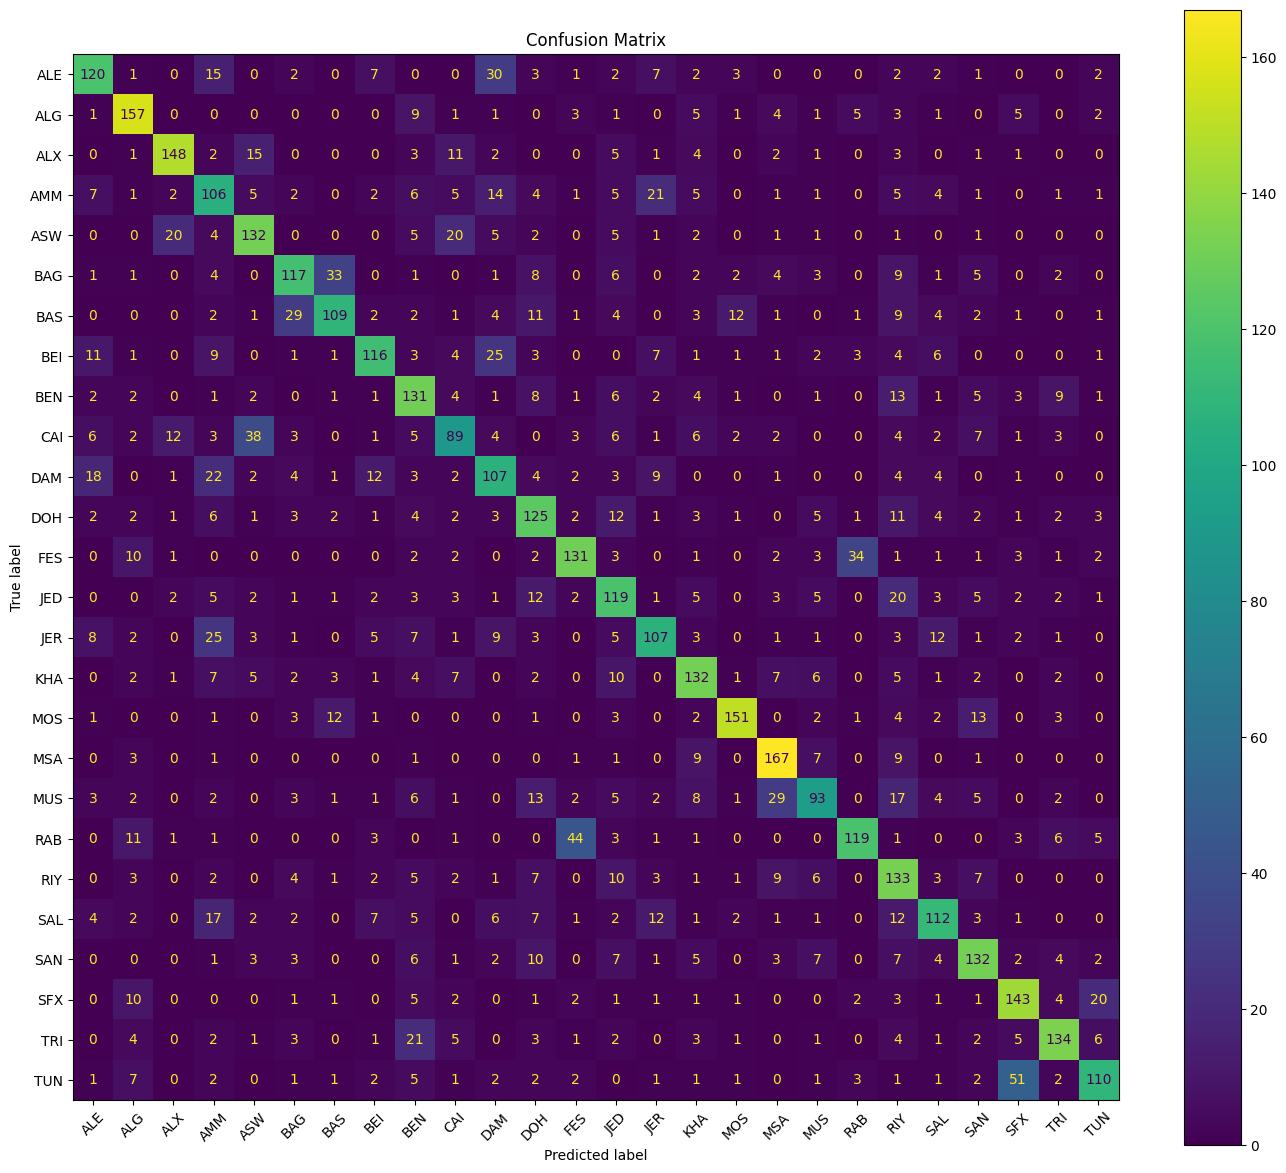

In [ ]:
import matplotlib.pyplot as plt

# Confusion Matrix
fig, ax = plt.subplots(figsize=(14, 12))  # You can increase size here
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ❌ Where there is Misclassification on Confusion Matrix and why?
---

### 🧠 **Overall Insights**

* **Diagonal dominance**: Most values are concentrated along the diagonal, indicating your model correctly classifies many dialects.
* **Confusions are generally between linguistically or geographically close cities** — which is expected and not necessarily a model flaw.

---

## 🔍 Major Misclassifications & Possible Reasons

### 🇸🇾 **Aleppo (ALE)**

* Misclassified as **Damascus (DAM)**, **Amman (AMM)**, and **Beirut (BEI)**.
* **Reason**: Aleppo and Damascus are both Syrian cities with overlapping Levantine features. Jordan is also close to Syria.

---

### 🇩🇿 **Algiers (ALG)**

* Few misclassifications, mostly confused with **Rabat (RAB)** and **Benghazi (BEN)**.
* **Reason**: North African (Maghrebi) dialects share strong French influence and syntactic patterns.

---

### 🇪🇬 **Alexandria (ALX)** and 🇪🇬 **Cairo (CAI)**

* Misclassified with each other and with **Aswan (ASW)**.
* **Reason**: All Egyptian dialects share a root in **Masri**, with some phonetic and lexical shifts regionally (e.g., Alexandria uses some coastal variants).

---

### 🇯🇴 **Amman (AMM)** and 🇵🇸 **Jerusalem (JER)**

* Mutually confused.
* **Reason**: Both cities are part of the **Southern Levant**, with nearly indistinguishable dialects in casual speech.

---

### 🇱🇧 **Beirut (BEI)** and 🇸🇾 **Damascus (DAM)**

* High confusion between them.
* **Reason**: Both are in the **central Levantine** zone. Historically and linguistically intertwined due to proximity and shared media influence.

---

### 🇮🇶 **Baghdad (BAG)**, 🇮🇶 **Basra (BAS)**, 🇮🇶 **Mosul (MOS)**

* Strong misclassifications between each other.
* **Reason**: All three are Iraqi cities. Differences are subtle and usually phonological rather than lexical. Also, high variance in dialect within Iraq.

---

### 🇸🇦 **Riyadh (RIY)** and 🇸🇦 **Jeddah (JED)**

* Some confusion between them.
* **Reason**: Though Riyadh is Najdi and Jeddah is Hijazi, modern urbanization, media exposure, and dialect leveling blur these lines in written/spoken text.

---

### 🇱🇾 **Benghazi (BEN)** and 🇱🇾 **Tripoli (TRI)**

* Mutual confusion.
* **Reason**: Both represent **Libyan Arabic**, and the distinction might require more phonological or prosodic features than text allows.

---

### 🇶🇦 **Doha (DOH)**, 🇴🇲 **Muscat (MUS)**, 🇾🇪 **Sanaa (SAN)**

* These Gulf dialects tend to show **cross-confusions**.
* **Reason**: Many Gulf states share similar grammatical and lexical forms due to tribal migrations and media overlap.

---

## ⚠️ Noteworthy Cross-Region Confusions

* Some confusion between **North African** and **Levantine** dialects, though minimal.
* Misclassifications of **Tunis (TUN)** → **Sfax (SFX)** → shows that even within the same country, city-specific dialects are hard to distinguish.


---



### 📰 Learnings from research paper
There is a research paper that experimented with MADAR, CAMeLBERT and many other datasets and models that I mentioned in the intro of this notebook. They came to an interesting conclusion as a result of their experiements that seems counter intuitive.
 - They noticed that even though pre-training data size increased, this didn't positively correlate with model performance.

 - They concluded that there was a positive correlation between varient proximity and urged researchers to focus more training models with this strategy in mind.
    - To speak plainly, we will see better results if the dataset that we fine tune and train on contains a larger vocabulary, rather than training on a large amount of noisy Arabic that was scraped from the web. The research on this paper extended tasks like named entity recognition, part of speech, sentiment analysis, dialect recognition, and poetry. With all these tasks in mind, models trained on datasets containing larger vocabulary performed better.

### What we can apply to our dialect analysis research
We can conclude that in order to achieve better results in dialect analysis, we need more data. But, the data that we need is data from all dialects to contain a wide variety of words. The larger vocabulary our model can train on, the more dimensions our data can have and become more seperable.



---

## 🏁 Conclusion

In this notebook, I fine-tuned a BERT-based transformer to classify 26 different Arabic dialects using the MADAR corpus. This task is particularly challenging due to the subtle linguistic overlap between dialects — often influenced by geography, history, and culture.

Despite these challenges, the model learned meaningful distinctions and demonstrated promising performance, especially in dialects with sufficient training data. This project highlights my expertise in:

* Multilingual and dialect-aware NLP modeling
* Training large-scale transformer models on limited-resource languages
* Optimizing and evaluating deep learning pipelines using TensorFlow, PyTorch & HuggingFace
* Drawing linguistically grounded insights from model behavior (e.g., confusion between Cairo and Alexandria dialects)

---

## 🚀 Future Work

To build on this project and enhance its real-world impact, here are the next steps I plan to take:

1. **Introduce Code-Switch Detection**: Many Arabic speakers mix dialects or use Modern Standard Arabic (MSA) with English/French. Integrating code-switch detection will make the model more robust to real-world social media or spoken inputs.

2. **Expand to Voice Data**: Apply the model to transcribed speech datasets and explore dialect detection in **ASR (Automatic Speech Recognition)** applications, which are vital for virtual assistants, smart services, and call center analytics.

3. **Train with Self-Supervised Learning**: Use contrastive learning (e.g., SimCLR) to improve representation learning on unlabeled Arabic text data, which is crucial for low-resource dialects.

4. **Deploy as an API or Streamlit App**: Wrap the model in a web-friendly interface or deploy as a REST API for easy access in production systems or educational demos.

---

## 🇸🇦 Aligning with Vision 2030

Saudi Arabia’s Vision 2030 highlights the need for cutting-edge AI systems rooted in the Arabic language and culture. Arabic NLP — especially dialect classification — is essential for:

* Government e-services tailored to local speech patterns
* Social media sentiment analysis for public opinion
* Smart city interfaces in NEOM and The Line
* Educational tools that adapt to regional dialects

By enhancing Arabic language understanding at scale, we support national goals in **AI, digital transformation, and cultural preservation**.

---

### 📩 Let’s Connect

If you're working on **Arabic AI, Saudi NLP initiatives, or Vision 2030-aligned projects**, I’d love to contribute. You can reach out via [LinkedIn](https://www.linkedin.com/in/justin-h-chang/), view more of my work on my [github](https://github.com/jhchang), or learn more about me on my [portfolio](https://justinchang.vercel.app/).

---
